# Imports

In [117]:
import pandas as pd
import numpy as np
from scipy import stats

 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import permutation_test_score

from mpl_toolkits.basemap import Basemap
import hazelbean as hb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import pickle

# Load dataset

In [123]:
###TODO load_new_data():

def load_baseline_df():
    crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
    df_land = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
    
    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0', 'country_ids',
           'ha_per_cell_5m'], axis=1)
    
    return df

def data_preprocessing(df):
    
    # Rename cols
    df = df.rename(columns={'bio12': 'precip', 'bio1': 'temperature',
                                'minutes_to_market_5m': 'min_to_market',
                                'gdp_per_capita_2000_5m': 'gdp_per_capita',
                                'gdp_2000': 'gdp'})
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    df = df[df['calories_per_ha'] != 0]    
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Lat/Lon
    df['sin_lon'] = df['lon'].apply(lambda x:np.sin(np.radians(x)))
    df = df.drop('lon',axis=1)
    #df['sin_lat'] = df['lat'].apply(lambda x:np.sin(np.radians(x)))
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)
        df = df.drop(col,axis=1)
        
        
    # Slope
    df['slope'] = df['slope'].apply(lambda x:x-90)
                
    
    # Cols to drop
    for col in ['pixel_id_float', 'land_mask']:
        df = df.drop(col,axis=1)
    
    #Set index 'pixel_id'
    df = df.set_index('pixel_id')

    return df

In [124]:
baseline_df = data_preprocessing(load_baseline_df())

In [264]:
X = df.drop(['calories_per_ha'], axis=1)
y = df['calories_per_ha']

# Load model

In [267]:
model_filename = '../ipbes_invest_crop_yield_project/output/Models/xgb3.sav'
regression = pickle.load(open(model_filename, 'rb'))

In [268]:
regression

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.02,
       max_delta_step=0, max_depth=10, min_child_weight=3, missing=nan,
       n_estimators=700, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.85)

# Apply model

In [130]:
simple_subset = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha']

s = [x for x in simple_subset if x !='calories_per_ha']

simple_subset_gdp = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'gdp','log_gdp_per_capita','log_gpw_population'
                  'temp_avg','precip',
                  'calories_per_ha']


In [269]:
y_predicted = regression.predict(X)

# Plot modeled results

In [ ]:
## Do I really match y and y_predicted correctly here????

In [281]:
compare = pd.DataFrame()

compare['log(cal_per_ha)'] = y
compare['log(cal_per_ha) predicted'] = y_predicted

compare['cal_per_ha'] = compare['log(cal_per_ha)'].apply(lambda x: pow(10,x))
compare['cal_per_ha predicted'] = compare['log(cal_per_ha) predicted'].apply(lambda x: pow(10,x))

compare['prediction error'] = compare['cal_per_ha predicted'] - compare['cal_per_ha']

## Scatterplots

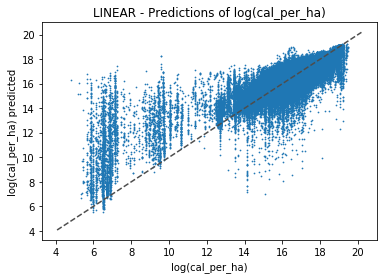

In [283]:
#Predictions of log(calories_per_ha)
ax = compare.plot.scatter(x='log(cal_per_ha)',y='log(cal_per_ha) predicted',s=0.5,title='XGB - Predictions of log(cal_per_ha)');
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3");

#plt.savefig('../ipbes_invest_crop_yield_project/output/Figures/Model_results/y_predicted_log--Linear_simplesubset.png')

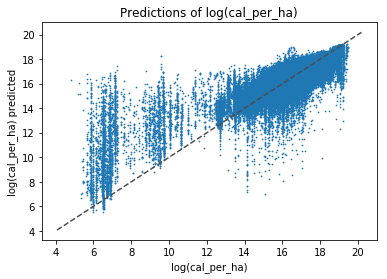

In [282]:
#Predictions of log(calories_per_ha)
ax = compare.plot.scatter(x='log(cal_per_ha)',y='log(cal_per_ha) predicted',s=0.5,title='Predictions of log(cal_per_ha)');
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3");


#plt.savefig('../ipbes_invest_crop_yield_project/output/Figures/Model_results/y_predicted_log--Linear_simplesubset.png')

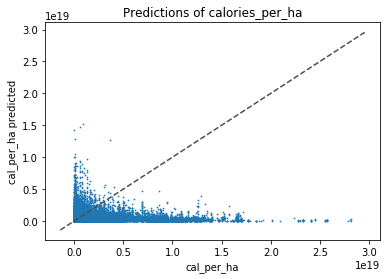

In [273]:
#Predictions of calories_per_ha
ax = compare.plot.scatter(x='cal_per_ha',y='cal_per_ha predicted',s=0.5,title='Predictions of calories_per_ha');
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3");

#plt.savefig('../ipbes_invest_crop_yield_project/output/Figures/Model_results/y_predicted--Linear_simplesubset.png')

## Maps

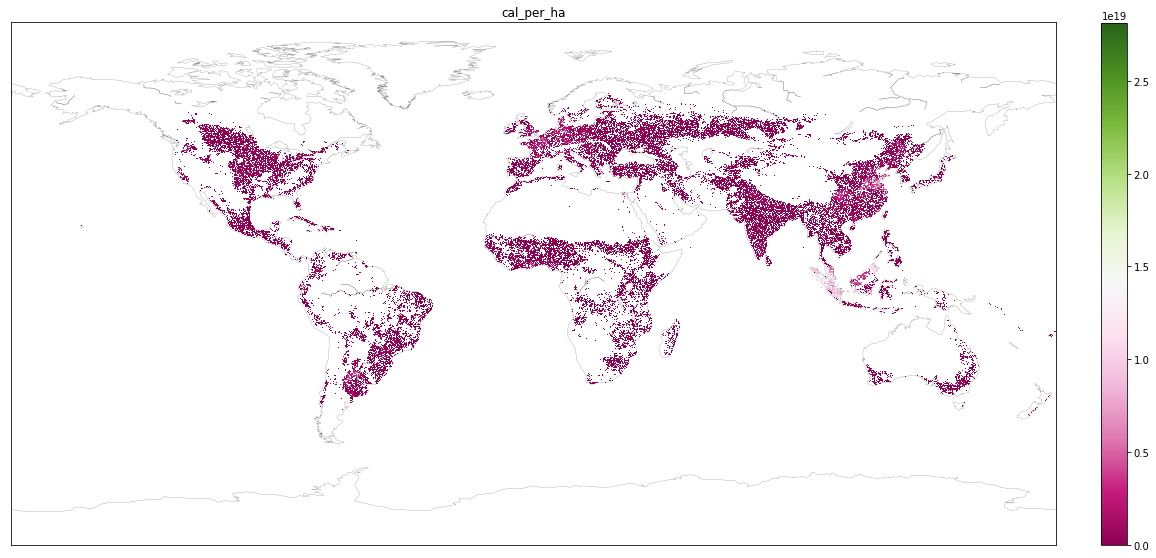

In [280]:
visualize_data(compare,'cal_per_ha')
               #savefig = '../ipbes_invest_crop_yield_project/output/Figures/Model_results/cal_per_ha--Linear_simplesubset.png')

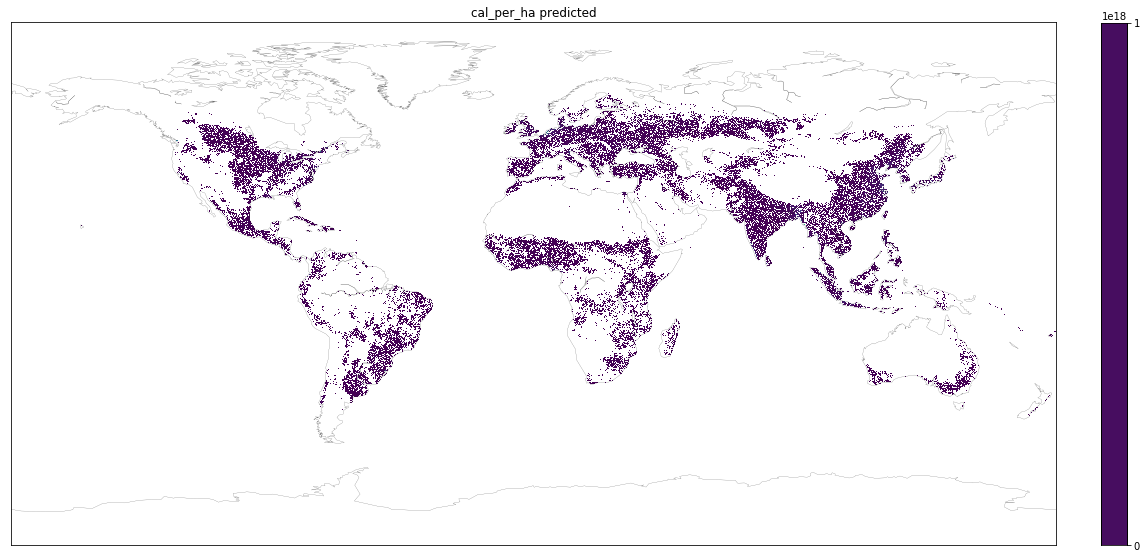

In [232]:
visualize_data(compare,'cal_per_ha predicted')

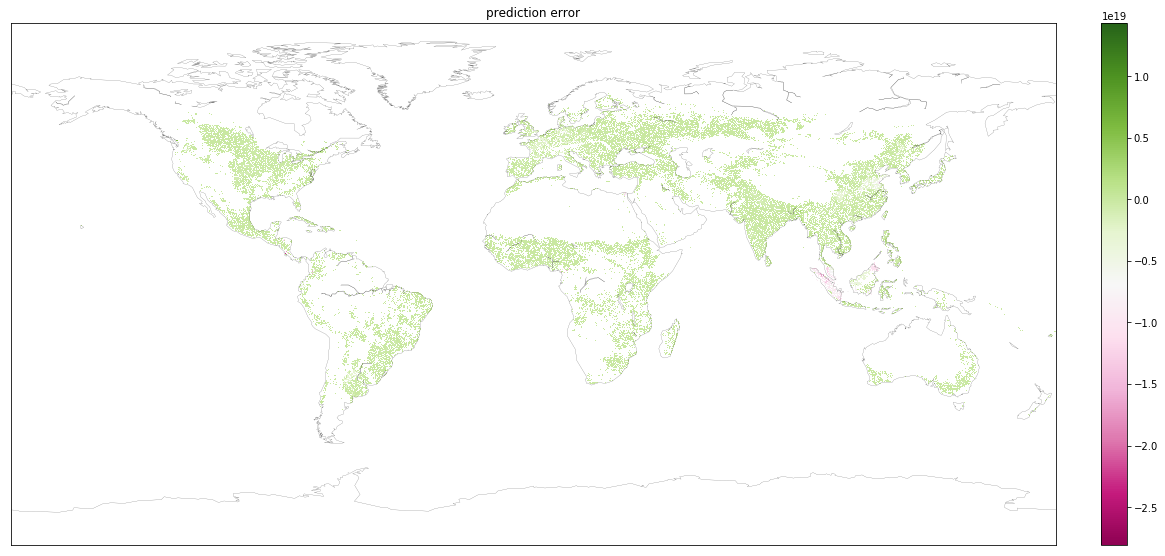

In [254]:
visualize_data(compare,'prediction error')

In [248]:
max(compare['prediction error'])

1.4330074864024664e+19

## Visualisation functions

In [279]:
## Geographical visualization function

def plot_col(df, col_name, shape=(2160, 4320)):
    cmap = plt.get_cmap('PiYG')
    ##cmap = customColorMap(cmap, df[col_name], start=0, stop=1.0, name='my_cmap')
    
    data = np.array(df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(data.reshape(shape)),cmap=cmap)
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    
    cbar = plt.colorbar(im, orientation='vertical',fraction=0.0234, pad=0.04)#,boundaries = [0,1e18])
    
    plt.title(col_name)
    plt.show()

def visualize_data(df,col_name,savefig=False):
    fig,axes = plt.subplots(1, 1, figsize=(20,15))

    #Make a zeros_df of length 9331200
    match_af = hb.ArrayFrame(country_ids_raster_path)
    zeros_array = np.zeros(match_af.size)
    zeros_df = pd.DataFrame(zeros_array)
    
    DF = df[col_name].reset_index()
    
    ### Merge with zeros_df to include non-ag pixels
    full_df = pd.merge(zeros_df, DF, left_index=True, right_on='pixel_id', how='outer')
    
    plot_col(full_df, col_name)
    
    if savefig != False:
        fig.savefig(savefig)

In [ ]:
# Visualize predicted results with new climates_csv_

#Df with new climate:
X_rcp = baseline_df_climateRCP


log_calperha_rcp = reg.predict(X_rcp)
calperha_rcp = pow(10,log_calperha_rcp)
add calperha_rcp col to baseline_df_climateRCP

visualize_data(calperha_rcp,DF=df_land)


In [250]:
from mpl_toolkits.axes_grid1 import AxesGrid

def customColorMap(cmap, serie, start=0, stop=1.0, name='my_cmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    vmax = max(serie)
    vmin = min(serie)
    
    midpoint= 1 - vmax / (vmax + abs(vmin))
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This function is deprecated. Please call randint(-15, 5 + 1) instead
  if __name__ == '__main__':


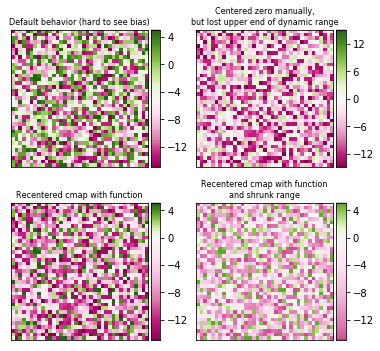

In [247]:
biased_data = np.random.random_integers(low=-15, high=5, size=(37,37))

orig_cmap = plt.get_cmap('PiYG')

shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.75, name='shifted')
shrunk_cmap = shiftedColorMap(orig_cmap, start=0.15, midpoint=0.75, stop=0.85, name='shrunk')

fig = plt.figure(figsize=(6,6))
grid = AxesGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5,
                label_mode="1", share_all=True,
                cbar_location="right", cbar_mode="each",
                cbar_size="7%", cbar_pad="2%")

# normal cmap
im0 = grid[0].imshow(biased_data, interpolation="none", cmap=orig_cmap)
grid.cbar_axes[0].colorbar(im0)
grid[0].set_title('Default behavior (hard to see bias)', fontsize=8)

im1 = grid[1].imshow(biased_data, interpolation="none", cmap=orig_cmap, vmax=15, vmin=-15)
grid.cbar_axes[1].colorbar(im1)
grid[1].set_title('Centered zero manually,\nbut lost upper end of dynamic range', fontsize=8)

im2 = grid[2].imshow(biased_data, interpolation="none", cmap=shifted_cmap)
grid.cbar_axes[2].colorbar(im2)
grid[2].set_title('Recentered cmap with function', fontsize=8)

im3 = grid[3].imshow(biased_data, interpolation="none", cmap=shrunk_cmap)
grid.cbar_axes[3].colorbar(im3)
grid[3].set_title('Recentered cmap with function\nand shrunk range', fontsize=8)

for ax in grid:
    ax.set_yticks([])
    ax.set_xticks([])

In [245]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

# RANGER !!!!

### Discuss results

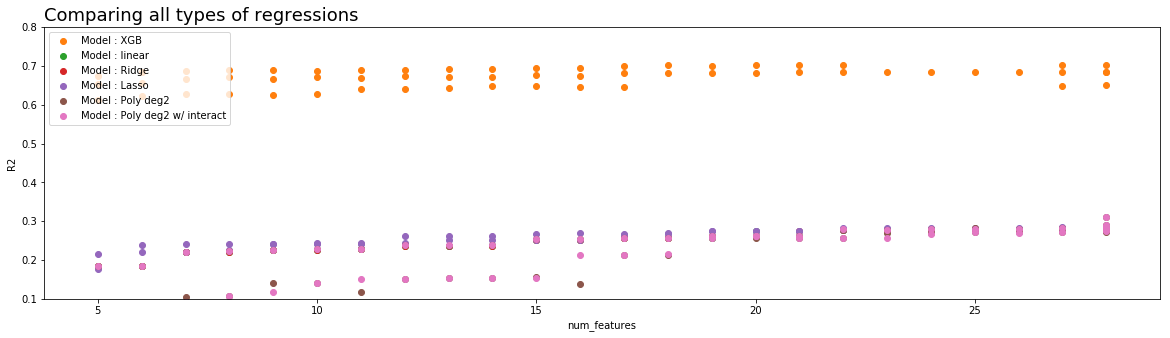

In [101]:
plot_R2_2params('num_features','Model',results_all,
                scatter=True,ylim=(0.10,0.8),
               title = 'Comparing all types of regressions',
               figsize = (20,5),
               color_palette = 'tab10')


# Several values for same model, same ≠ of features because different options (e.g different parameters alpha for Lasso,
# different subset of data for Poly: RFE vs. RFE BUT climzones.)


In [13]:
## Compare models by R2 scores

def plot_R2_2params(param_x, param_color, xgb_tuning,scatter=False,
                    ylim=None,title=None,figsize=(20,5),color_palette='Dark2'):

    fig, ax = plt.subplots(figsize=figsize)


    palette = plt.get_cmap(color_palette)
    num=0
    for param_color_value in xgb_tuning[param_color].unique():
        num+=1
        x = (xgb_tuning[xgb_tuning[param_color]==param_color_value][param_x])
        y = (xgb_tuning[xgb_tuning[param_color]==param_color_value]['R2'])
        #labels= (xgb_tuning[xgb_tuning[param_color]==learning_rate][param_color])
        if scatter == False:
            P = plt.plot(x,y, marker='.',color=palette(num), linewidth=2, alpha=0.9,
                 label=(str(param_color)+' : ' +str(param_color_value)))
        if scatter == True:
            P = plt.scatter(x,y, marker='o',color=palette(num),
                 label=(str(param_color)+' : ' +str(param_color_value)))
        
    plt.legend(loc=2, ncol=1)
    
    if title == None:
        title = "Comparing models by "+ param_x +" and "+ param_color
    plt.title(title, loc='left', fontsize=18, fontweight=0, color='black')

    plt.xlabel(param_x)
    plt.ylabel("R2")
    
    # Y lim
    if ylim != None:
        if scatter == False:
            P[0].axes.set_ylim(ylim)
        if scatter == True:
            P.axes.set_ylim(ylim)

In [33]:
# Subset of columns chosen to be metrics easily available for 2050.
# Soil : chosen "'workability_index'" because most often chosen among soil variables by RFE

simple_subset_cols = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha']

simple_subset_cols_gdp = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'gdp','log_gdp_per_capita','log_gpw_population'
                  'temp_avg','precip',
                  'calories_per_ha']